In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from cmt_analysis_utils import read_bids
from assign_helper import Assigner

## Here, we just demonstrate that it can visualize how (probably crappy) an assignment generated by CMT is

### The assignment helper can also suggest and do reviewer swaps and more, not (yet) demonstrated

In [2]:
# First, quota's (for the few that have them set)

# ReviewerRelevance, # CMT: Users -> Reviewers -> Manage (more) :: Actions -> Export -> Quotas
df_pc_quota = pd.read_csv("data/ReviewerQuotas.txt", delimiter='\t')
df_pc_quota.rename(columns={'Reviewer Email': 'Email'}, inplace=True)
df_pc_quota.set_index('Email', inplace=True)
df_pc_quota

,Quota
Email,
non.existant@cs.kuleuven.be,2


In [3]:
# Let's make one big dataframe with all the scores

# Relevance (computed by CMT based on subject area)
# ReviewerRelevance, # CMT: Users -> Reviewers -> Manage (more) :: Actions -> Export -> Relevance Scores
df_pc_scores = pd.read_csv("data/ReviewerRelevances.txt", delimiter='\t')
df_pc_scores.rename(columns={'# Paper ID': 'Paper ID', 'Reviewer Email': 'Email'}, inplace=True)

# Bids, # CMT: Submissions :: Actions -> Export to XML -> Reviewer Bids
filename = "data/Bids.xml"
df_pc_bids = read_bids(filename)
df_pc_scores = df_pc_scores.merge(df_pc_bids, on=['Paper ID', 'Email'], how="outer")
df_pc_scores.loc[df_pc_scores['Bid'].isna(), 'Bid'] = '1 - Not Entered'

# ReviewerConflicts, # CMT: Submissions :: Actions -> Export to Tab Delimited -> Reviewer Conflicts
df_pc_confl = pd.read_csv("data/ReviewerConflicts.txt", delimiter='\t')
df_pc_confl.rename(columns={'# Paper ID': 'Paper ID', 'Reviewer Email': 'Email'}, inplace=True)
df_pc_confl['Conflict'] = True
df_pc_scores = df_pc_scores.merge(df_pc_confl, on=['Paper ID', 'Email'], how="outer")
df_pc_scores['Conflict'] = df_pc_scores['Conflict'].replace(np.nan, False)

# set relevance to 0 if missing (reviewers that did not enter subject areas?)
# same for other nans
df_pc_scores['Relevance'] = df_pc_scores['Relevance'].replace(np.nan, 0.0)
df_pc_scores['Bid'] = df_pc_scores['Bid'].replace(np.nan, '1 - Not Entered')
df_pc_scores['Bid_nr'] = df_pc_scores['Bid_nr'].replace(np.nan, 1)
df_pc_scores['Conflict'] = df_pc_scores['Conflict'].replace(np.nan, False)

# lets add the number of positive bids too... there is at least one weirdo who bid A LOT
b_cnt = df_pc_bids.loc[(df_pc_bids['Bid'] != '2 - Not Willing') & (df_pc_bids['Bid'] != '1 - Not Entered'), ['Paper ID', 'Email']].groupby('Email').count().rename(columns={'Paper ID': 'nPosBids'})
df_pc_scores.drop(columns='nPosBids', errors='ignore')
df_pc_scores = df_pc_scores.join(b_cnt, on='Email', how="left")
df_pc_scores['nPosBids'] = df_pc_scores['nPosBids'].replace(np.nan, 0)

# Done
df_pc_scores

<ipython-input-3-7f419858184d>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pc_scores['Conflict'] = df_pc_scores['Conflict'].replace(np.nan, False)


,Paper ID,Email,Relevance,Bid_nr,Bid,Conflict,nPosBids
0,101,Petra.Kralj.Novak@ijs.si,0.25,1.0,1 - Not Entered,False,1.0
1,101,ana.nymous@example.com,0.10,5.0,5 - Eager,False,1.0
2,101,asja.fischer@rub.de,0.25,1.0,1 - Not Entered,False,2.0
3,101,greg@csd.auth.gr,0.25,1.0,1 - Not Entered,False,1.0
4,101,non.existant@cs.kuleuven.be,0.10,4.0,4 - Willing,True,3.0
5,101,tias.guns@kuleuven.be,0.00,2.0,2 - Not Willing,False,2.0
6,101,tira.lala@example.com,0.10,4.0,4 - Willing,False,1.0
7,101,train.ticket@cs.kuleuven.be,0.00,1.0,1 - Not Entered,False,1.0
8,101,train.ticket@example.com,0.00,1.0,1 - Not Entered,False,0.0
9,103,Petra.Kralj.Novak@ijs.si,0.25,3.0,3 - In A Pinch,False,1.0


In [4]:
# Let's determine our own score: bid should go first, then best of relevance/nd2TPMS
# ALT version: scale by 20/30/35 for pinch/willing/eager (so difference of 20/10/5),
# so that downgrades are more discerneable in Tscore difference later
df_pc_scores['Tscore'] = df_pc_scores['Relevance'].replace(np.nan, 0.0) + -100*(df_pc_scores['Bid'] == '2 - Not Willing') + 20*(df_pc_scores['Bid'] == '3 - In A Pinch') + 30*(df_pc_scores['Bid'] == '4 - Willing') + 35*(df_pc_scores['Bid'] == '5 - Eager')

/home/tias/organizeren/ecmlpkdd22_pc/program_chair_scripts/assign_helper.py:45: FutureWarning: The provided callable <function amax at 0x7f920457f670> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  allrevw = self.df_scores.groupby('Email').agg(nPosBids=('nPosBids', np.max))
/home/tias/organizeren/ecmlpkdd22_pc/program_chair_scripts/assign_helper.py:47: FutureWarning: The provided callable <function amin at 0x7f920457f820> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  summ = self.df_assign.groupby('Email').agg(len=(col,len), lst=(col, lambda x: sorted(np.round(x,1))), amin=(col, np.min), amax=(col, np.max)).sort_values(['amin','len'])
/home/tias/organizeren/ecmlpkdd22_pc/program_chair_scripts/assign_helper.py:47: FutureWarning: The provided

All reviewer quota satisfied.
3 papers assigned



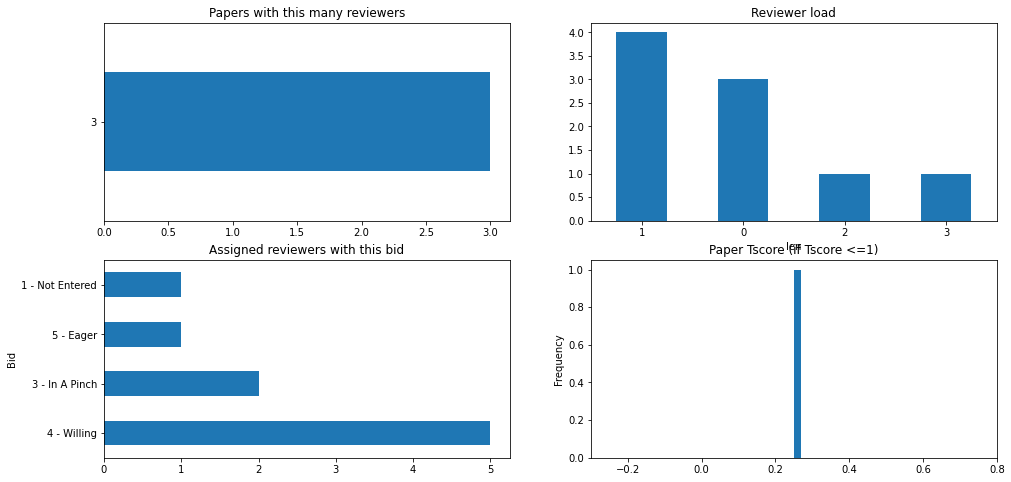

In [5]:
# reread from CMT
fname = "data/Assignments.xml"
a = Assigner(fname, df_pc_scores, df_pc_quota)
a.plot_overview()